In [2]:
import sys
import os
sys.path = [os.path.abspath('../')] + sys.path

from tick.hawkes import SimuHawkesExpKernels, ModelHawkesExpKernLeastSq
import os
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline
from pylab import rcParams
import numpy as np

from tick.solver import AGD
from tick.prox import ProxZero

from scipy.misc import derivative
from scipy.optimize import minimize, fmin_l_bfgs_b

import datetime

from multiprocessing import Pool, cpu_count
import re
import traceback

%load_ext autoreload
%autoreload 2
plt.style.use('dark_background')

# Global utilities

In [3]:
def plot_coeffs(mus, alphas, coeffs=None):
    dim = mus.shape[0]
    if coeffs is None:
        n_plots = 1
    else:
        n_plots = 3
    
    # Deal with mu
    rcParams['figure.figsize'] = 20, 1*n_plots
    ax_original = plt.subplot(n_plots, 1, 1)
    ax_original.matshow([mus], cmap='Blues', vmin=0)
    ax_original.set_ylabel('mu org')
    
    if coeffs is not None:
        ax_estimated = plt.subplot(n_plots, 1, 2)
        mus_ = coeffs[0:dim]
        ax_estimated.matshow([mus_], cmap='Blues', vmin=0)
        ax_estimated.set_ylabel('mu est')
        
        diff_matrix = mus_ - mus
        max_diff = np.max(np.abs(diff_matrix))
        ax_diff = plt.subplot(n_plots, 1, 3)
        im_diff = ax_diff.matshow([diff_matrix], cmap='bwr', vmin=-max_diff, vmax=max_diff)
        ax_diff.set_ylabel('mu diff')
        
    plt.show()
    
    # Deal with alpha
    rcParams['figure.figsize'] = 4*n_plots, 4
    ax_original = plt.subplot(1, n_plots, 1)
    ax_original.matshow(alphas, cmap='Blues')
    ax_original.set_xlabel('original alphas')
    
    if coeffs is not None:
        ax_estimated = plt.subplot(1, n_plots, 2)
        alphas_ = coeffs[dim:].reshape((dim, dim))
        ax_estimated.matshow(alphas_, cmap='Blues')
        ax_estimated.set_xlabel('estimated alphas')
        
        ax_diff = plt.subplot(1, n_plots, 3)
        diff_matrix = alphas_ - alphas
        max_diff = np.max(np.abs(diff_matrix))
        im_diff = ax_diff.matshow(diff_matrix, cmap='bwr', vmin=-max_diff, vmax=max_diff)
        ax_diff.set_xlabel('alphas diff')
        
        divider4 = make_axes_locatable(ax_diff)
        cax4 = divider4.append_axes("right", size="20%", pad=0.05)
        cbar4 = plt.colorbar(im_diff, cax=cax4)
        
    plt.show()


# Hawkes simulation

In [4]:
def block_matrix(dimension: int = 100,
                 blocks_ranges: list = None,
                 min_value: float = 0., max_value: float = 0.2,
                 noise: float = 0.):
    A = np.zeros((dimension, dimension))
    for block_range in blocks_ranges:
        nodes = np.array(block_range, dtype=int)
        for a in nodes:
            for b in nodes:
                A[a, b] = min_value + (max_value - min_value) * \
                                      np.random.rand(1)
    A *= 0.8 / np.linalg.norm(A, 2)
    return A

def plot_ticks_hist(ticks, title=''):
    n_ticks = [len(t) for t in ticks]
    rcParams['figure.figsize'] = 16, 3
    plt.step(np.arange(len(n_ticks)), n_ticks)
    plt.title(title)
    plt.xlabel('dimension')
    plt.ylabel('n jumps')
    plt.show()

## Coeffs creation

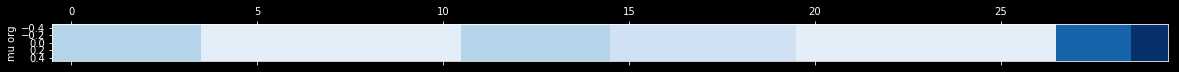

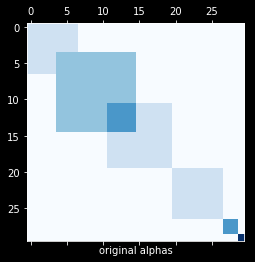

--------------------------------------------------
Launching simulation using SimuHawkesExpKernels...
Done simulating using SimuHawkesExpKernels in 2.30e-02 seconds.


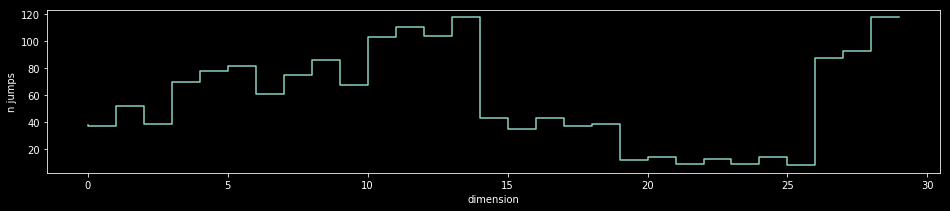

In [8]:
np.random.seed(123)

dim = 30

beta = 1
betas = np.ones((dim, dim)) * beta

if dim == 100:
    blocks_ranges = [
        range(0 , 12),
        range(10, 30),
        range(22, 60),
        range(60, 90),
        range(90, 97),
        range(97, 100)
    ]
if dim == 30:
    blocks_ranges = [
        range(0 , 7),
        range(4, 15),
        range(11, 20),
        range(20, 27),
        range(27, 29),
        range(29, 30),
    ]

if dim == 30:
    A0 = np.zeros((dim, dim))
    mu0 = np.zeros(dim)
    for i, block_range in enumerate(blocks_ranges):
        nodes = np.array(block_range, dtype=int)
        for a in nodes:
            for b in nodes:
                if i == 0:
                    A0[a, b] = 1
                elif i == 1:
                    A0[a, b] = 2
                elif i == 2:
                    A0[a, b] += 1
                elif i == 3:
                    A0[a, b] = 1
                elif i == 4:
                    A0[a, b] = 3
                elif i == 5:
                    A0[a, b] = 5
        a, b = block_range[0], block_range[-1] + 1
        if i == 0:
            mu0[a: b] = 0.3
        elif i == 1:
            mu0[a: b] = 0.1
        elif i == 2:
            mu0[a: b] += 0.2
        elif i == 3:
            mu0[a: b] = 0.1
        elif i == 4:
            mu0[a: b] = 0.8
        elif i == 5:
            mu0[a: b] = 1.0

elif dim == 100:
    A0 = np.zeros((dim, dim))
    mu0 = np.zeros(dim)
    for i, block_range in enumerate(blocks_ranges):
        nodes = np.array(block_range, dtype=int)
        for a in nodes:
            for b in nodes:
                if i == 0:
                    A0[a, b] = 2
                elif i == 1:
                    A0[a, b] += 1
                elif i == 2:
                    A0[a, b] += 1.3
                elif i == 3:
                    A0[a, b] = 1.5
                elif i == 4:
                    A0[a, b] = 3
                elif i == 5:
                    A0[a, b] = 3
        a, b = block_range[0], block_range[-1] + 1
        if i == 0:
            mu0[a: b] = 0.3
        elif i == 1:
            mu0[a: b] = 0.1
        elif i == 2:
            mu0[a: b] += 0.2
        elif i == 3:
            mu0[a: b] = 0.1
        elif i == 4:
            mu0[a: b] = 0.8
        elif i == 5:
            mu0[a: b] = 1.0
            
hawkes = SimuHawkesExpKernels(A0, betas, baseline=mu0)
spectral_radius = hawkes.spectral_radius()
A0 *= 0.8 / spectral_radius

plot_coeffs(mu0, A0)

hawkes = SimuHawkesExpKernels(A0, betas, baseline=mu0, end_time=100)
hawkes.simulate()

simulation = np.array(hawkes.timestamps)
plot_ticks_hist(simulation)

## Hawkes simulation

In [10]:
def get_next_file_name(directory, filename, extension='npy'):
    os.makedirs(directory, exist_ok=True)
    existing_files = os.listdir(directory)
    
    suffix = 0
    txt_suffix = '%03d' % suffix # '%03d' allow us to have leading zeros
    full_filename = '%s_%s.%s' % (filename, txt_suffix, extension)
    while full_filename in existing_files:
        suffix += 1
        txt_suffix = '%03d' % suffix # '%03d' allow us to have leading zeros
        full_filename = '%s_%s.%s' % (filename, txt_suffix, extension)
    return full_filename


In [11]:
n_train_hawkes = 5
n_test_hawkes = 0

# directory_prefix = '/data/data/public/jmlr_hawkes_data/'
directory_prefix = '/Users/martin/Downloads/jmlr_hawkes_data/'

def get_train_directory(dim):
    train_directory = directory_prefix + 'train_hawkes/dim_%i/' % (dim)
    return train_directory

def get_train_directory_simulations(dim, run_time=None):
    train_directory_simulations = get_train_directory(dim) + 'T_%0.f/' % (run_time)
    return train_directory_simulations
    
def get_test_directory_simulations(dim, run_time):
    test_directory = directory_prefix + 'test_hawkes/dim_%i/' % (dim)
    test_directory_simulations = test_directory + 'T_%0.f/' % (run_time)
    return test_directory_simulations
    
original_coeffs = np.hstack((mu0, A0.reshape(dim*dim)))
os.makedirs(get_train_directory(dim), exist_ok=True)
original_coeffs_path = os.path.join(get_train_directory(dim), 'original_coeffs.npy')
print(original_coeffs_path)
if os.path.exists(original_coeffs_path):
    previous_coeffs = np.load(original_coeffs_path)
    np.testing.assert_almost_equal(previous_coeffs, original_coeffs)
    print('file existed already and was the same')
else:
    np.save(original_coeffs_path, original_coeffs)

/Users/martin/Downloads/jmlr_hawkes_data/train_hawkes/dim_30/original_coeffs.npy


In [12]:
def simulate_and_save_hawkes(directory, run_time, prefix='simulation'):
    hawkes = SimuHawkesExpKernels(A0, betas, baseline=mu0, end_time=run_time, verbose=False)
    hawkes.simulate()
    simulation = np.array(hawkes.timestamps)
    filename = get_next_file_name(directory, prefix)
    file_path = os.path.join(directory, filename)
    np.save(file_path, simulation)
    return file_path

In [13]:
from itertools import product

run_times = [500, 1000]

n_cpu = cpu_count()
train_args_list = [(get_train_directory_simulations(dim, run_time), run_time) 
                   for _, run_time in product(range(n_train_hawkes), run_times)]
test_args_list = [(get_test_directory_simulations(dim, run_time), run_time) 
                  for _, run_time in product(range(n_test_hawkes), run_times)]


args_list = train_args_list #  + test_args_list

pool_sim = Pool(n_cpu)
file_paths = pool_sim.starmap(simulate_and_save_hawkes, args_list)
pool_sim.close()
pool_sim.join()

print('\n'.join(file_paths))


/Users/martin/Downloads/jmlr_hawkes_data/train_hawkes/dim_30/T_500/simulation_000.npy
/Users/martin/Downloads/jmlr_hawkes_data/train_hawkes/dim_30/T_1000/simulation_000.npy
/Users/martin/Downloads/jmlr_hawkes_data/train_hawkes/dim_30/T_500/simulation_002.npy
/Users/martin/Downloads/jmlr_hawkes_data/train_hawkes/dim_30/T_1000/simulation_003.npy
/Users/martin/Downloads/jmlr_hawkes_data/train_hawkes/dim_30/T_500/simulation_001.npy
/Users/martin/Downloads/jmlr_hawkes_data/train_hawkes/dim_30/T_1000/simulation_002.npy
/Users/martin/Downloads/jmlr_hawkes_data/train_hawkes/dim_30/T_500/simulation_003.npy
/Users/martin/Downloads/jmlr_hawkes_data/train_hawkes/dim_30/T_1000/simulation_001.npy
/Users/martin/Downloads/jmlr_hawkes_data/train_hawkes/dim_30/T_500/simulation_004.npy
/Users/martin/Downloads/jmlr_hawkes_data/train_hawkes/dim_30/T_1000/simulation_004.npy


In [14]:
n_train_hawkes

5

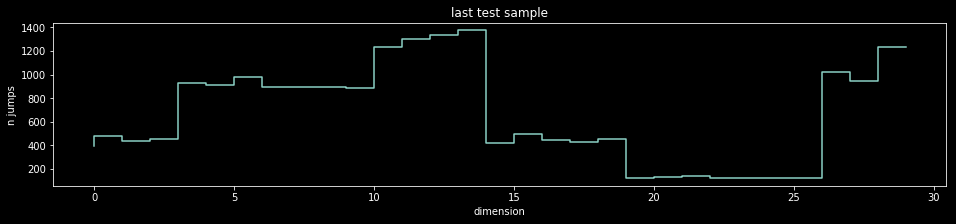

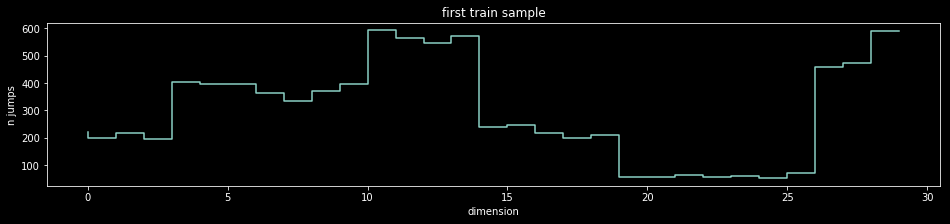

In [15]:
last_test = np.load(file_paths[-1])
plot_ticks_hist(last_test, title='last test sample')
first_train = np.load(file_paths[0])
plot_ticks_hist(first_train, title='first train sample')

# Hawkes contrast weight computations

In [16]:
# directory_prefix = '/data/data/public/jmlr_hawkes_data/'
directory_prefix = '/Users/martin/Downloads/jmlr_hawkes_data/'

logger = print

def load_coeffs(original_coeffs_path):
    if os.path.exists(original_coeffs_path):
        original_coeffs = np.load(original_coeffs_path)
        logger('found coeffs at %s' % original_coeffs_path)
    else:
        raise(FileNotFoundError('No coeffs found at %s' % original_coeffs_path))
    
    original_mu = original_coeffs[:dim]
    original_alpha = original_coeffs[dim:].reshape((dim, dim))
    plot_coeffs(original_mu, original_alpha)
    return original_coeffs


def load_directory(directory):
    all_ticks = []
    if os.path.exists(directory):
        for filename in os.listdir(directory):
            if filename.endswith('npy'):
                file_path = os.path.join(directory, filename)
                ticks = np.load(file_path)
                # we must convert it to a list of numpy arrays
                ticks = list(ticks)
                # we must have at least one jump per dimension
                minimum_of_jumps = min([len(dim_ticks) for dim_ticks in ticks])
                if minimum_of_jumps > 0:
                    all_ticks += [ticks]
    return all_ticks


def load_data(dim, run_time):
    train_directory = directory_prefix + 'train_hawkes/dim_%i/' % (dim)
    train_directory_simulations = train_directory + 'T_%0.f/' % (run_time)
    test_directory = directory_prefix + 'test_hawkes/dim_%i/' % (dim)
    test_directory_simulations = test_directory + 'T_%0.f/' % (run_time)

    original_coeffs_path = os.path.join(train_directory, 'original_coeffs.npy')
    original_coeffs = load_coeffs(original_coeffs_path)
    
    train_ticks = load_directory(train_directory_simulations)
    print('Retrieved %i train samples' % len(train_ticks))

    test_ticks = load_directory(test_directory_simulations)
    print('Retrieved %i test samples' % len(test_ticks))
    
    n_train_samples = 10
    if len(train_ticks) > n_train_samples:
        train_ticks = train_ticks[:n_train_samples]
        print('We keep %i train samples' % len(train_ticks))
    
    if len(train_ticks) < n_train_samples:
        print(len(train_ticks))
    assert(len(train_ticks) >= n_train_samples)

    n_test_samples = 10
    if len(test_ticks) > n_test_samples:
        test_ticks = test_ticks[:n_train_samples]
        print('We keep %i test samples' % len(test_ticks))
        
    return original_coeffs, train_ticks, test_ticks

In [17]:
# directory_prefix = '/data/data/public/jmlr_hawkes_data/'
directory_prefix = '/Users/martin/Downloads/jmlr_hawkes_data/'
import pickle


report_for_pre_compute_file_name = 'report_for_pre_compute.txt'
def logger(*args):
    print(*args)
    with open(report_for_pre_compute_file_name, 'a') as report_for_pre_compute_file:
        report_for_pre_compute_file.write(', '.join([str(arg) for arg in args]) + '\n')

def create_if_missing(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

def load_directory(directory, extension):
    if os.path.exists(directory):
        return [filename for filename in os.listdir(directory) if filename.endswith(extension)]
    
def extract_index(file_name, pattern, extension):
    regex = '%s_(\d+).%s' % (pattern, extension)
    match = re.search(regex, file_name)
    return match.group(1)

def precompute_weights(simulation_file, train_directory_simulations, train_directory_pre_computed):
    ticks = np.load(os.path.join(train_directory_simulations, simulation_file))
    # we must convert it to a list of numpy arrays
    ticks = list(ticks)

    # fit ticks and precompute weights
    model = ModelHawkesExpKernLeastSq(1., n_threads=1).fit(ticks)
    loss = model.loss(np.ones(model.n_coeffs))
    index = extract_index(simulation_file, 'simulation', 'npy')

    precompute_file_name = 'precomputed_%s.pkl' % index
    pre_computed_file = os.path.join(train_directory_pre_computed, precompute_file_name)
    with open(pre_computed_file, 'wb') as save_file:
        pickle.dump(model, save_file)
    logger('saved', pre_computed_file.replace(directory_prefix, ''), loss)


def pre_compute_hawkes(dim, run_time, max_pre_computed_hawkes, n_total_threads=20):
    train_directory = directory_prefix + 'train_hawkes/dim_%i/' % (dim)
    train_directory_simulations = train_directory + 'T_%0.f/' % (run_time)
    
    train_directory_pre_computed = train_directory + 'T_%0.f/pre_computed_contrast/' % (run_time)
    create_if_missing(train_directory_pre_computed)
    pretrained_hawkes = [filename for filename in os.listdir(train_directory_pre_computed) if filename.endswith('pkl')]
    
    available_simulations = load_directory(train_directory_simulations, 'npy')
    
    if len(available_simulations) < max_pre_computed_hawkes:
        logger('WARNING FOR dim=%i, T=%f, only %i simuations available' % (dim, run_time, len(available_simulations)))
    
    already_precomputed_index = [extract_index(precomputed_file, 'precomputed', 'pkl') 
                                 for precomputed_file in load_directory(train_directory_pre_computed, 'pkl')]
    
    to_compute_simulations = [simulation_file for simulation_file in available_simulations
                             if extract_index(simulation_file, 'simulation', 'npy') not in already_precomputed_index]
        
    selected_simulations = [simulation_file for simulation_file in to_compute_simulations
                            if int(extract_index(simulation_file, 'simulation', 'npy')) < max_pre_computed_hawkes]
    
    if (len(selected_simulations) > 0):
        args = [(simulation_file, train_directory_simulations, train_directory_pre_computed) 
                for simulation_file in selected_simulations]
        pool = Pool(min(n_total_threads, len(selected_simulations)))
        try:
            info_list = pool.starmap(precompute_weights, args)
            pool.close()
            pool.join()
        except Exception as e:
            traceback.print_exc()
        finally:
            pool.terminate()
        
            


In [18]:

dims = [30]
run_times = [500, 1000]
max_pre_computed_hawkes = 5

for dim in dims:
    for run_time in run_times:
        now = datetime.datetime.today().strftime('%Y-%m-%d %H:%M')
        logger('\n' + '-'*30 + '\nDIM=%i T=%.0f : %s' % (dim, run_time, now) + '\n')
        pre_compute_hawkes(dim, run_time, max_pre_computed_hawkes)


------------------------------
DIM=30 T=500 : 2018-10-22 16:33



saved train_hawkes/dim_30/T_500/pre_computed_contrast/precomputed_000.pkl 609.4847160074655


saved train_hawkes/dim_30/T_500/pre_computed_contrast/precomputed_002.pkl 609.2550641148432


saved train_hawkes/dim_30/T_500/pre_computed_contrast/precomputed_001.pkl 634.3351534667256


saved train_hawkes/dim_30/T_500/pre_computed_contrast/precomputed_004.pkl 641.0924282513796


saved train_hawkes/dim_30/T_500/pre_computed_contrast/precomputed_003.pkl 666.6194224868235



------------------------------
DIM=30 T=1000 : 2018-10-22 16:33



saved train_hawkes/dim_30/T_1000/pre_computed_contrast/precomputed_001.pkl 636.5402146592727


saved train_hawkes/dim_30/T_1000/pre_computed_contrast/precomputed_000.pkl 629.4916010473887


saved train_hawkes/dim_30/T_1000/pre_computed_contrast/precomputed_002.pkl 651.5663013748001


saved train_hawkes/dim_30/T_1000/pre_computed_contrast/precomputed_003.pkl 654.1331419958703


saved train_hawkes/dim_30/T_1000/pre_computed_contrast/precomputed_004.pkl 663.7731539550545


In [20]:
def load_precomputed_hawkes(dim, run_time, n_pre_computed_hawkes):
    train_directory = directory_prefix + 'train_hawkes/dim_%i/' % (dim)    
    train_directory_pre_computed = train_directory + 'T_%0.f/pre_computed_contrast/' % (run_time)
    selected_models = load_directory(train_directory_pre_computed, 'pkl')[:n_pre_computed_hawkes]
    
    for model_file in selected_models:
        with open(os.path.join(train_directory_pre_computed, model_file), 'rb') as stored_file:
            model = pickle.load(stored_file)
            print(model.decays)
        # print(model.loss(np.ones(model.n_coeffs)))
        # print(1./model.get_lip_best())
        # print(model.hessian(None))
        # 
        # from scipy.sparse.linalg import inv
        # %time inv(model.hessian(None))
        # print(inv(model.hessian(None)) * model.hessian(x))
    
    
dim = 30
run_time = 1000
n_pre_computed_hawkes = 1
load_precomputed_hawkes(dim, run_time, n_pre_computed_hawkes)

1.0


In [45]:
import tick
tick

<module 'tick' from '/Users/martin/Projects/tick/tick/__init__.py'>